In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [4]:
df = pd.read_csv('/Users/Devyani/msads/ml2/finalproj/merged_compas_data_final.csv')

In [5]:
df.shape

(7340907, 20)

In [6]:
df.head()

,arrest_charge_degree,person_id,is_recid,juv_fel_count,juv_misd_count,juv_other_count,prison_in,prison_out,prison_duration_days,legal_status,marital_status,race,sex,age,priors_count,c_charge_degree,filing_type,filing_agency,initial_charge,initial_statute
0,(F3),533,1,0,0,0,2013-04-23 09:37:13.000000,2013-04-24 01:57:01.000000,0.680417,Pretrial,Single,African-American,Female,23,0,(F3),No Information/ Transfer to Misdemeanor,Fort Lauderdale PD,Driving While License Revoked,322.34(5)
1,(F3),533,1,0,0,0,2013-04-23 09:37:13.000000,2013-04-24 01:57:01.000000,0.680417,Pretrial,Single,African-American,Female,23,0,(F3),Transfer to County Court,Fort Lauderdale PD,Petit Theft,812.014(3)(a)
2,(F3),533,1,0,0,0,2013-04-23 09:37:13.000000,2013-04-24 01:57:01.000000,0.680417,Pretrial,Single,African-American,Female,23,0,(F3),No Information/ Transfer to Misdemeanor,Fort Lauderdale PD,Driving While License Revoked,322.34(5)
3,(F3),533,1,0,0,0,2013-04-23 09:37:13.000000,2013-04-24 01:57:01.000000,0.680417,Pretrial,Single,African-American,Female,23,0,(F3),Transfer to County Court,Fort Lauderdale PD,Petit Theft,812.014(3)(a)
4,(F3),533,1,0,0,0,2013-04-23 09:37:13.000000,2013-04-24 01:57:01.000000,0.680417,Pretrial,Single,African-American,Female,23,0,(F3),No Information/ Transfer to Misdemeanor,Fort Lauderdale PD,Driving While License Revoked,322.34(5)


In [7]:
df['prison_in'] = pd.to_datetime(df['prison_in'], errors='coerce')
df['prison_out'] = pd.to_datetime(df['prison_out'], errors='coerce')
df['prison_in_year'] = df['prison_in'].dt.year.astype('Int64')
df['prison_out_year'] = df['prison_out'].dt.year.astype('Int64')

In [8]:
df = df.drop(columns=['person_id', 'prison_in', 'prison_out'])
#dropping person_id for overfitting 
#dropping prison_in and prison_out as mlp cannot handle timestamp data
#extracted years as numeric features instead

In [14]:
X = df.drop(columns=['is_recid'])
y = df['is_recid'].values

In [15]:
numeric_features = X.select_dtypes(include=['int64', 'float64', 'Int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [17]:
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'prison_duration_days', 'age', 'priors_count', 'prison_in_year', 'prison_out_year']
Categorical features: ['arrest_charge_degree', 'legal_status', 'marital_status', 'race', 'sex', 'c_charge_degree', 'filing_type', 'filing_agency', 'initial_charge', 'initial_statute']


## pause!

In [ ]:
## yikes

In [30]:
import scipy.sparse
import numpy as np

In [56]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features)
])

## danger zone :(

In [87]:
X_sparse = preprocessor.fit_transform(X)  
assert scipy.sparse.issparse(X_sparse)

In [88]:
class SparseDataset(Dataset):
    def __init__(self, X_sparse, y_array):
        self.X = X_sparse.tocsr()
        self.y = y_array

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if isinstance(idx, (list, np.ndarray, torch.Tensor)):
            x_batch = self.X[idx].toarray()
            y_batch = [1.0 if self.y[i] == 1 else 0.0 for i in idx]
            x_tensor = torch.tensor(x_batch, dtype=torch.float32)
            y_tensor = torch.tensor(y_batch, dtype=torch.float32)
            return x_tensor, y_tensor
        else:
            x = self.X[idx].toarray().squeeze()
            x_tensor = torch.tensor(x, dtype=torch.float32)
            y_tensor = torch.tensor(1.0 if self.y[idx] == 1 else 0.0, dtype=torch.float32)
            return x_tensor, y_tensor

In [89]:
y_array = y if isinstance(y, np.ndarray) else y.to_numpy()

In [90]:
full_dataset = SparseDataset(X_sparse, y_array)
full_loader = DataLoader(full_dataset, batch_size=1024, shuffle=True)

## make model

In [95]:
import torch.nn as nn

In [97]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [99]:
input_dim = X_sparse.shape[1]
model = MLP(input_dim)

In [100]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [101]:
labels = [full_dataset[i][1].item() for i in range(100)]
print(set(labels))

{0.0, 1.0}


## training

In [105]:
num_epochs = 10 #test with small num

In [107]:
train_losses = []
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    batch_count = 0

    for batch_X, batch_y in full_loader:
        preds = model(batch_X)
        loss = criterion(preds.view(-1, 1), batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_count += 1

    avg_loss = epoch_loss / batch_count
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

Epoch 1 | Avg Loss: 0.2176
Epoch 2 | Avg Loss: 0.1313
Epoch 3 | Avg Loss: 0.1092
Epoch 4 | Avg Loss: 0.0983
Epoch 5 | Avg Loss: 0.0914
Epoch 6 | Avg Loss: 0.0865
Epoch 7 | Avg Loss: 0.0826
Epoch 8 | Avg Loss: 0.0799
Epoch 9 | Avg Loss: 0.0777
Epoch 10 | Avg Loss: 0.0761


In [108]:
torch.save(model, "mlp_full_model.pth")
print("Full model saved to mlp_full_model.pth")

Full model saved to mlp_full_model.pth


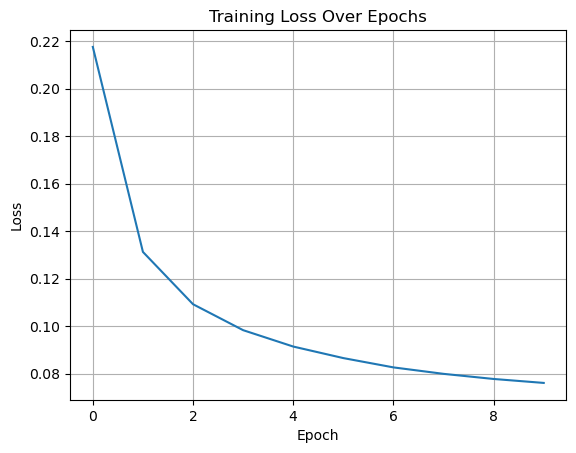

In [112]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

### evaluation

In [114]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

In [124]:
model.eval()

MLP(
  (model): Sequential(
    (0): Linear(in_features=3662, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [126]:
all_preds = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in full_loader:
      

        batch_preds = model(batch_X)
        preds = (batch_preds.view(-1) >= 0.5).int().cpu().numpy()
        targets = batch_y.view(-1).int().cpu().numpy()

        all_preds.extend(preds)
        all_targets.extend(targets)

y_preds = np.array(all_preds)
y_true = np.array(all_targets)

In [127]:
print(f"\nAccuracy: {accuracy_score(y_true, y_preds):.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_preds))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_preds))


Accuracy: 0.9738

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95   1855305
           1       0.98      0.99      0.98   5485602

    accuracy                           0.97   7340907
   macro avg       0.97      0.96      0.96   7340907
weighted avg       0.97      0.97      0.97   7340907


Confusion Matrix:
[[1716525  138780]
 [  53286 5432316]]
